# Graph Neural Network Project: Citation Network Classification

##  Project Overview

**Objective:** Build a Graph Attention Network (GAT) to classify research papers in a citation network.

**Dataset:** Cora Citation Network
- 2,708 scientific publications (nodes)
- 5,429 citation links (edges)
- 7 classes (research areas)
- 1,433 features per paper (bag-of-words)

**Key features of project**
- Real world application of GNNs
- Demonstrates graph structure learning
- Shows attention mechanism benefits
- Complete ML pipeline from data to deployment

**Project Pipeline:**
1. Data loading and exploration
2. Graph visualization
3. Custom GAT model with multiple attention heads
4. Training pipeline with early stopping
5. Evaluation and visualization
6. Attention weight analysis

## Imports

In [1]:
# Install required packages
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install torch-geometric
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install networkx matplotlib seaborn scikit-learn pandas numpy
!pip install plotly

Looking in indexes: https://download.pytorch.org/whl/cpu
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
  Using cached torch_scatter-2.1.2.tar.gz (108 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [20 lines of output]
      Traceback (most recent call last):
        File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 389, in <module>
          main()
        File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 373, in main
          json_out["return_val"] = hook(**hook_input["kwargs"])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/pip/_

In [2]:
# library imports
import os
import random
import warnings
from typing import Dict, List, Tuple, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.manifold import TSNE
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv
from torch_geometric.utils import to_networkx

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def set_seed(seed: int = 42):
    """Set random seeds for reproducibility across all libraries."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Using device: {device}")

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔧 Using device: cpu


## Data Loading 

**Cora dataset** - a classic benchmark for GNNs

In [3]:
def load_cora_dataset(root: str = './data/Cora') -> Tuple:
    dataset = Planetoid(root=root, name='Cora')
    data = dataset[0].to(device)
    print(f"   Dataset: {dataset.name}")
    print(f"   Number of graphs: {len(dataset)}")
    print(f"   Number of features: {dataset.num_features}")
    print(f"   Number of classes: {dataset.num_classes}")
    return dataset, data
dataset, data = load_cora_dataset()

Processing...


   Dataset: Cora
   Number of graphs: 1
   Number of features: 1433
   Number of classes: 7


Done!


In [4]:
def explore_graph_data(data) -> Dict:
    stats = {
        'num_nodes': data.num_nodes,
        'num_edges': data.num_edges,
        'num_features': data.num_features,
        'num_classes': data.y.max().item() + 1,
        'avg_degree': (data.num_edges / data.num_nodes),
        'has_isolated_nodes': data.has_isolated_nodes(),
        'has_self_loops': data.has_self_loops(),
        'is_undirected': data.is_undirected(),
    }
    
    print("\n Graph Statistics:")
    print(f"Number of nodes: {stats['num_nodes']:,}")
    print(f"Number of edges: {stats['num_edges']:,}")
    print(f"Number of features per node: {stats['num_features']:,}")
    print(f"Number of classes: {stats['num_classes']}")
    print(f"Average node degree: {stats['avg_degree']:.2f}")
    print(f"Has isolated nodes: {stats['has_isolated_nodes']}")
    print(f"Has self-loops: {stats['has_self_loops']}")
    print(f"Is undirected: {stats['is_undirected']}")
    
    # Dataset split
    print("\nDataset Split:")
    print(f"Training nodes: {data.train_mask.sum().item():,} ({100 * data.train_mask.sum().item() / data.num_nodes:.1f}%)")
    print(f"Validation nodes: {data.val_mask.sum().item():,} ({100 * data.val_mask.sum().item() / data.num_nodes:.1f}%)")
    print(f"Test nodes: {data.test_mask.sum().item():,} ({100 * data.test_mask.sum().item() / data.num_nodes:.1f}%)")
    
    return stats

# Explore the data
stats = explore_graph_data(data)


 Graph Statistics:
Number of nodes: 2,708
Number of edges: 10,556
Number of features per node: 1,433
Number of classes: 7
Average node degree: 3.90
Has isolated nodes: False
Has self-loops: False
Is undirected: True

Dataset Split:
Training nodes: 140 (5.2%)
Validation nodes: 500 (18.5%)
Test nodes: 1,000 (36.9%)


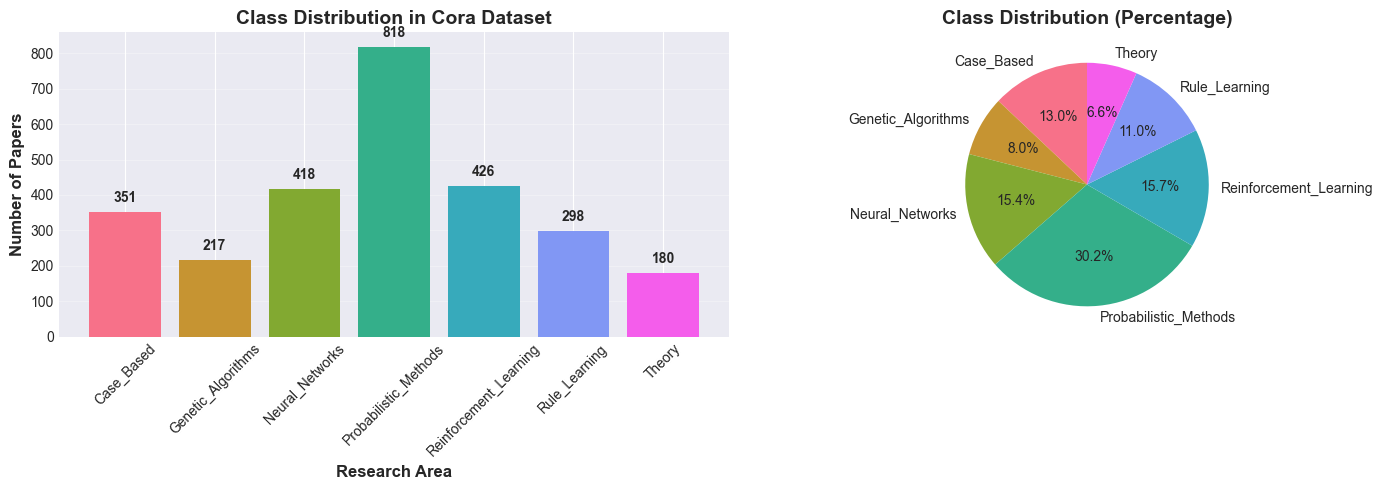


Class Distribution:
   Case_Based: 351 papers (13.0%)
   Genetic_Algorithms: 217 papers (8.0%)
   Neural_Networks: 418 papers (15.4%)
   Probabilistic_Methods: 818 papers (30.2%)
   Reinforcement_Learning: 426 papers (15.7%)
   Rule_Learning: 298 papers (11.0%)
   Theory: 180 papers (6.6%)


In [5]:
def visualize_class_distribution(data, dataset):
    class_names = [
        'Case_Based',
        'Genetic_Algorithms', 
        'Neural_Networks',
        'Probabilistic_Methods',
        'Reinforcement_Learning',
        'Rule_Learning',
        'Theory'
    ]
    # Count nodes per class
    class_counts = [(data.y == i).sum().item() for i in range(dataset.num_classes)]
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].bar(class_names, class_counts, color=sns.color_palette("husl", 7))
    axes[0].set_xlabel('Research Area', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Number of Papers', fontsize=12, fontweight='bold')
    axes[0].set_title('Class Distribution in Cora Dataset', fontsize=14, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', alpha=0.3)
    for i, v in enumerate(class_counts):
        axes[0].text(i, v + 20, str(v), ha='center', va='bottom', fontweight='bold')
    axes[1].pie(class_counts, labels=class_names, autopct='%1.1f%%', 
                colors=sns.color_palette("husl", 7), startangle=90)
    axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    print("\nClass Distribution:")
    for i, name in enumerate(class_names):
        print(f"   {name}: {class_counts[i]} papers ({100*class_counts[i]/sum(class_counts):.1f}%)")
visualize_class_distribution(data, dataset)

## Graph Visualization

Creating network visualization (showing 500 nodes)...


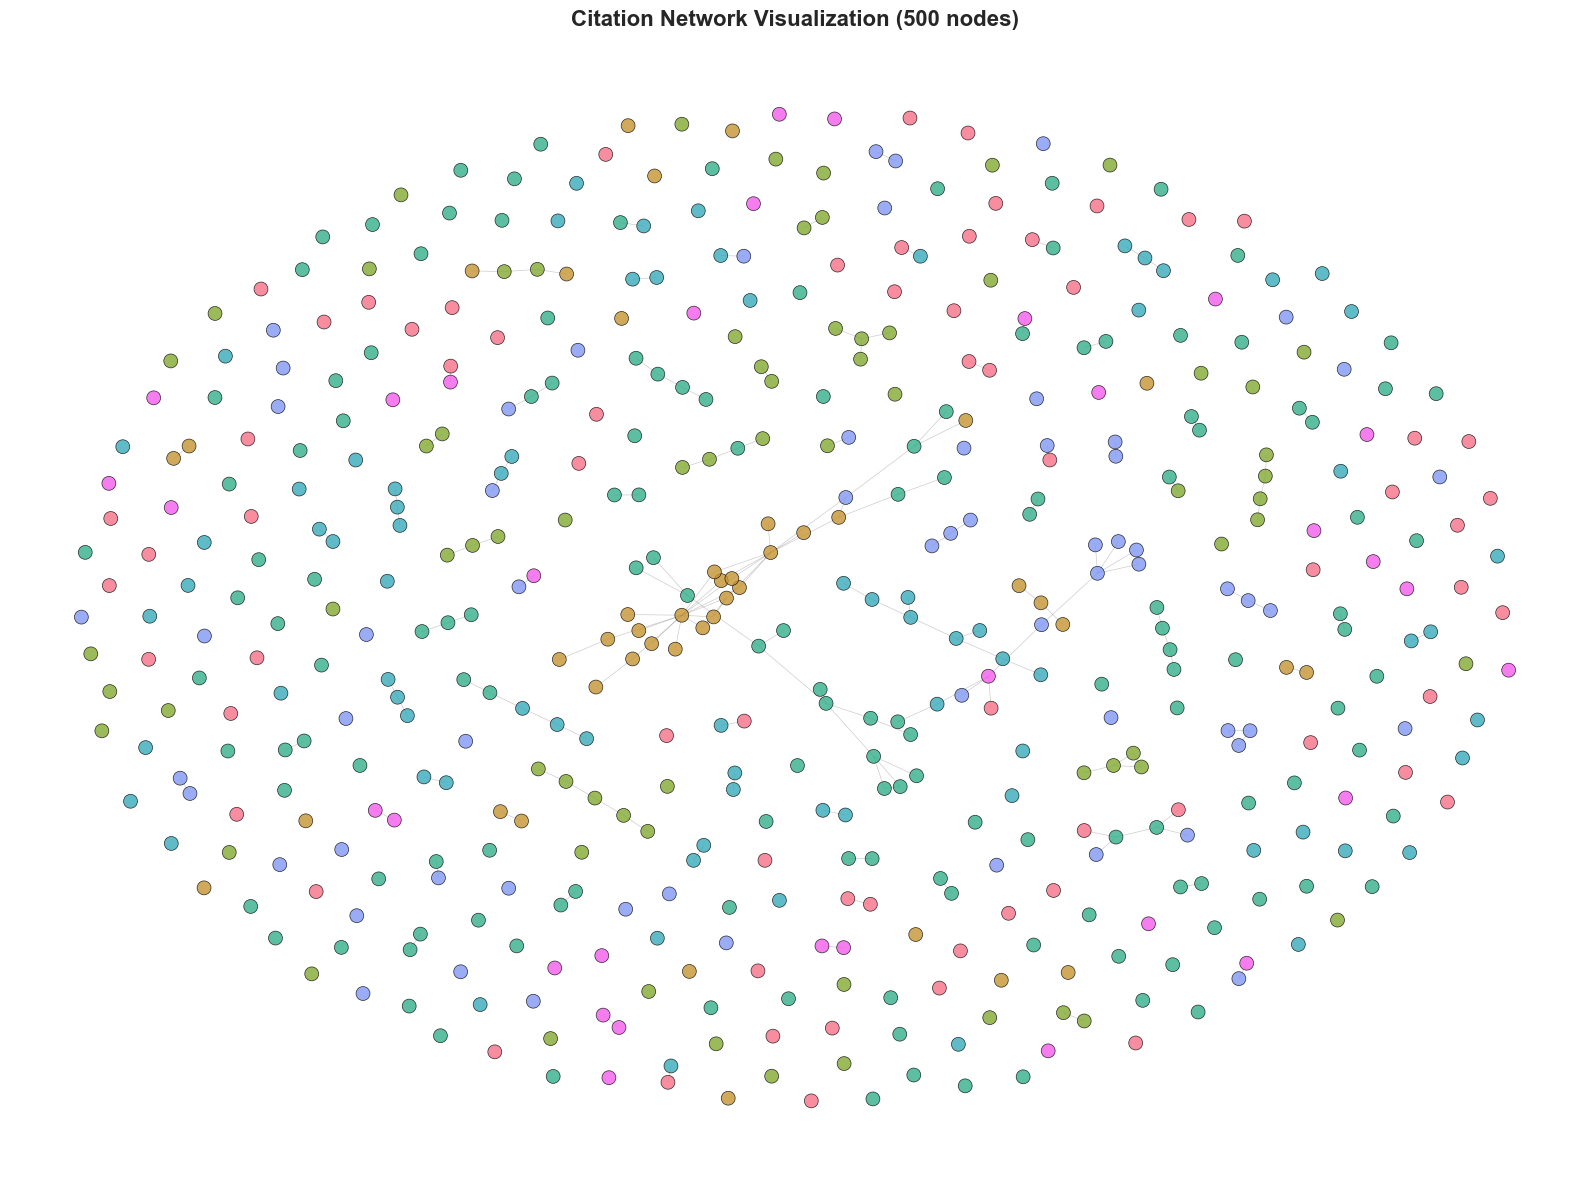

   Each color represents a different research area
   Edges show citation relationships between papers


In [6]:
def visualize_graph_network(data, num_nodes: int = 500):
    print(f"Creating network visualization (showing {num_nodes} nodes)...")
    subset_indices = torch.randperm(data.num_nodes)[:num_nodes]
    edge_mask = torch.isin(data.edge_index[0], subset_indices) & \
                torch.isin(data.edge_index[1], subset_indices)
    subset_edges = data.edge_index[:, edge_mask]
    old_to_new = {old.item(): new for new, old in enumerate(subset_indices)}
    remapped_edges = torch.tensor(
        [[old_to_new[edge[0].item()], old_to_new[edge[1].item()]] 
         for edge in subset_edges.t()]
    ).t()
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    G.add_edges_from(remapped_edges.t().tolist())
    subset_labels = data.y[subset_indices].cpu().numpy()
    colors = sns.color_palette("husl", 7)
    node_colors = [colors[label] for label in subset_labels]
    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                          node_size=100, alpha=0.8, edgecolors='black', linewidths=0.5)
    nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)
    plt.title(f'Citation Network Visualization ({num_nodes} nodes)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    print(f"   Each color represents a different research area")
    print(f"   Edges show citation relationships between papers")

# Visualize the network
visualize_graph_network(data, num_nodes=500)

## Graph Attention Network (GAT) Model

**What is GAT?**
- GAT uses attention mechanisms to weight neighbor contributions
- Multiple attention heads capture different relationship patterns
- More flexible than standard GCN (Graph Convolutional Networks)

**Architecture:**
- 2 GAT layers with multi-head attention
- Layer normalization for stable training
- Dropout for regularization (prevents overfitting)
- Residual connections for better gradient flow

In [7]:
class GraphAttentionNetwork(nn.Module):
    def __init__(self, 
                 num_features: int,
                 num_classes: int,
                 hidden_dim: int = 64,
                 num_heads: int = 8,
                 dropout: float = 0.6):
        super(GraphAttentionNetwork, self).__init__()
        self.dropout = dropout
        self.conv1 = GATConv(
            in_channels=num_features,
            out_channels=hidden_dim,
            heads=num_heads,
            dropout=dropout,
            concat=True  
        )
        self.norm1 = nn.LayerNorm(hidden_dim * num_heads)
        self.conv2 = GATConv(
            in_channels=hidden_dim * num_heads,
            out_channels=num_classes,
            heads=1,
            dropout=dropout,
            concat=False  
        )
    def forward(self, x, edge_index, return_attention_weights=False):
        attention_weights = {}
        if return_attention_weights:
            x, (edge_index_1, alpha_1) = self.conv1(x, edge_index, 
                                                     return_attention_weights=True)
            attention_weights['layer1'] = (edge_index_1, alpha_1)
        else:
            x = self.conv1(x, edge_index)
        
        x = self.norm1(x)  
        x = F.elu(x)  
        x = F.dropout(x, p=self.dropout, training=self.training)  
        if return_attention_weights:
            x, (edge_index_2, alpha_2) = self.conv2(x, edge_index, 
                                                     return_attention_weights=True)
            attention_weights['layer2'] = (edge_index_2, alpha_2)
            return x, attention_weights
        else:
            x = self.conv2(x, edge_index)
            return x

def count_parameters(model):
    """Count the number of trainable parameters in the model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
model = GraphAttentionNetwork(
    num_features=dataset.num_features,
    num_classes=dataset.num_classes,
    hidden_dim=64,
    num_heads=8,
    dropout=0.6
).to(device)
print("\n Model Architecture:")
print(model)
print(f"\nTotal trainable parameters: {count_parameters(model):,}")



 Model Architecture:
GraphAttentionNetwork(
  (conv1): GATConv(1433, 64, heads=8)
  (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (conv2): GATConv(512, 7, heads=1)
)

Total trainable parameters: 739,861


##  Training Pipeline with Early Stopping

**Key Features:**
- Early stopping to prevent overfitting
- Learning rate scheduling
- Metric tracking

In [8]:
class EarlyStopping:
    def __init__(self, patience: int = 20, min_delta: float = 0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None  
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
            self.counter = 0
def train_epoch(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    pred = out[data.train_mask].argmax(dim=1)
    acc = (pred == data.y[data.train_mask]).float().mean()
    return loss.item(), acc.item()
@torch.no_grad()
def evaluate(model, data, mask):
    model.eval()
    out = model(data.x, data.edge_index)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(out[mask], data.y[mask])
    pred = out[mask].argmax(dim=1)
    acc = (pred == data.y[mask]).float().mean()
    return loss.item(), acc.item()
def train_model(model, data, num_epochs: int = 500, lr: float = 0.005, 
                weight_decay: float = 5e-4, patience: int = 30): 
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    early_stopping = EarlyStopping(patience=patience)
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'test_loss': [],
        'test_acc': []
    }
    # Training loop
    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train_epoch(model, data, optimizer, criterion)
        # Validate
        val_loss, val_acc = evaluate(model, data, data.val_mask)
        test_loss, test_acc = evaluate(model, data, data.test_mask)
        # Store metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        scheduler.step(val_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:03d} | "
                  f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f} | "
                  f"Test Acc: {test_acc:.4f}")
        # Early stopping check
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            # Load best model
            model.load_state_dict(early_stopping.best_model)
            break
    return history


# Train the model
history = train_model(
    model=model,
    data=data,
    num_epochs=500,
    lr=0.005,
    weight_decay=5e-4,
    patience=30
)

Epoch 010 | Train Loss: 0.5691, Acc: 0.7786 | Val Loss: 0.8026, Acc: 0.7720 | Test Acc: 0.7940
Epoch 020 | Train Loss: 0.3562, Acc: 0.8786 | Val Loss: 1.2895, Acc: 0.7200 | Test Acc: 0.7360
Epoch 030 | Train Loss: 0.3246, Acc: 0.9000 | Val Loss: 1.1555, Acc: 0.7320 | Test Acc: 0.7440

Early stopping triggered at epoch 39


## Training Visualization

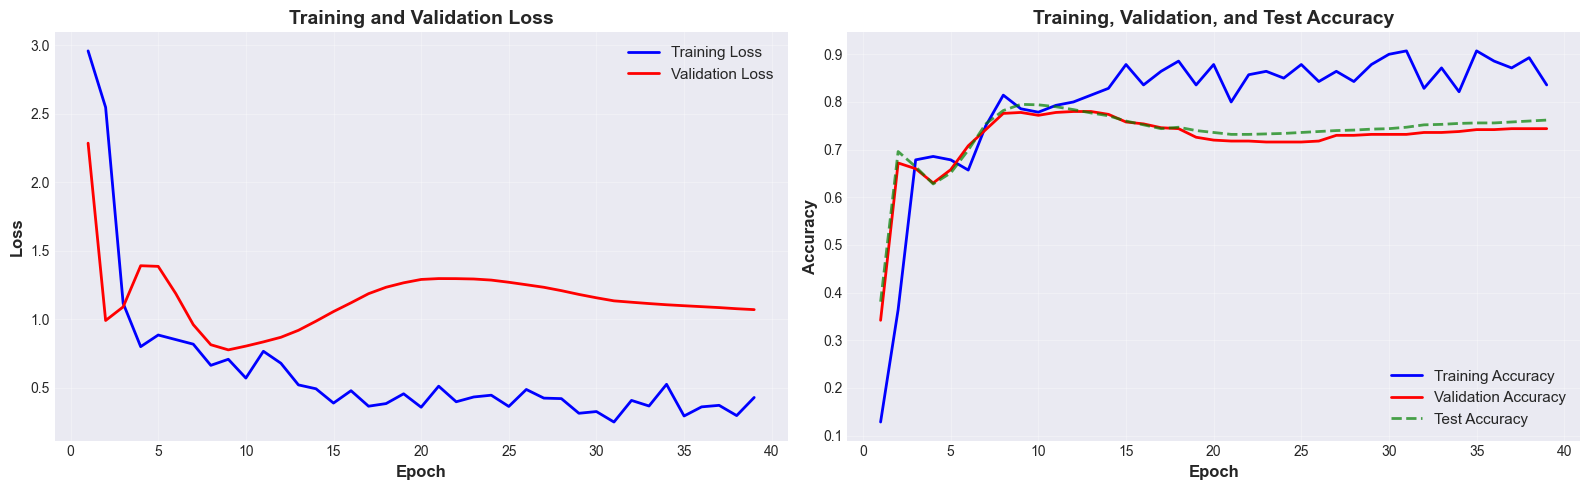

Best Validation Accuracy: 0.7800
Final Test Accuracy: 0.7620
Training completed in 39 epochs


In [9]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Plot loss
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # Plot accuracy
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
    axes[1].plot(epochs, history['test_acc'], 'g--', label='Test Accuracy', linewidth=2, alpha=0.7)
    axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    axes[1].set_title('Training, Validation, and Test Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    print(f"Best Validation Accuracy: {max(history['val_acc']):.4f}")
    print(f"Final Test Accuracy: {history['test_acc'][-1]:.4f}")
    print(f"Training completed in {len(history['train_loss'])} epochs")
plot_training_history(history)

##  Detailed Evaluation & Metrics


Overall Test Accuracy: 0.7620 (76.20%)
                 Class  Precision   Recall  F1-Score  Support
            Case_Based   0.598726 0.723077  0.655052      130
    Genetic_Algorithms   0.757576 0.824176  0.789474       91
       Neural_Networks   0.870504 0.840278  0.855124      144
 Probabilistic_Methods   0.901186 0.714734  0.797203      319
Reinforcement_Learning   0.773333 0.778523  0.775920      149
         Rule_Learning   0.829545 0.708738  0.764398      103
                Theory   0.482456 0.859375  0.617978       64
Macro Average    - Precision: 0.7448, Recall: 0.7784, F1: 0.7507
Weighted Average - Precision: 0.7912, Recall: 0.7620, F1: 0.7683


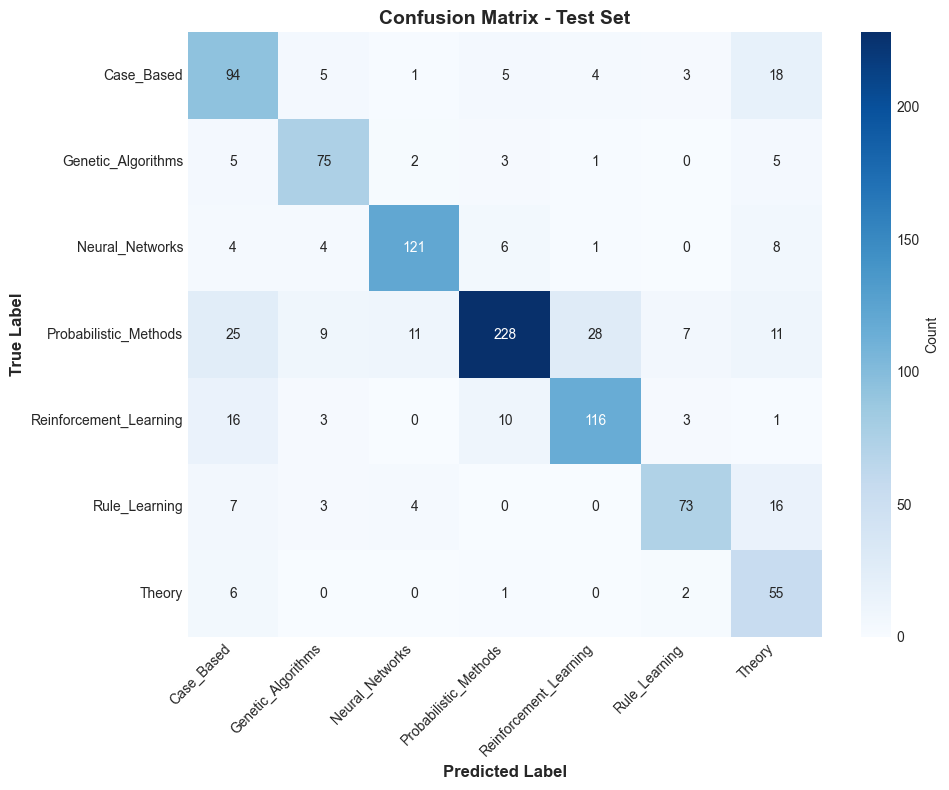

In [10]:
@torch.no_grad()
def get_predictions(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    return pred.cpu().numpy(), data.y.cpu().numpy()
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


def detailed_evaluation(model, data, dataset):
    class_names = [
        'Case_Based', 'Genetic_Algorithms', 'Neural_Networks',
        'Probabilistic_Methods', 'Reinforcement_Learning',
        'Rule_Learning', 'Theory'
    ]
    pred, y_true = get_predictions(model, data)
    test_mask = data.test_mask.cpu().numpy()
    y_test_true = y_true[test_mask]
    y_test_pred = pred[test_mask]
    test_acc = accuracy_score(y_test_true, y_test_pred)
    print(f"\nOverall Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test_true, y_test_pred, average=None
    )
    
    results_df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })
    print(results_df.to_string(index=False))
    macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
        y_test_true, y_test_pred, average='macro'
    )
    weighted_p, weighted_r, weighted_f1, _ = precision_recall_fscore_support(
        y_test_true, y_test_pred, average='weighted'
    )
    print(f"Macro Average    - Precision: {macro_p:.4f}, Recall: {macro_r:.4f}, F1: {macro_f1:.4f}")
    print(f"Weighted Average - Precision: {weighted_p:.4f}, Recall: {weighted_r:.4f}, F1: {weighted_f1:.4f}")
    plot_confusion_matrix(y_test_true, y_test_pred, class_names)
    return results_df
results = detailed_evaluation(model, data, dataset)

## Node Embeddings Visualization (t-SNE)

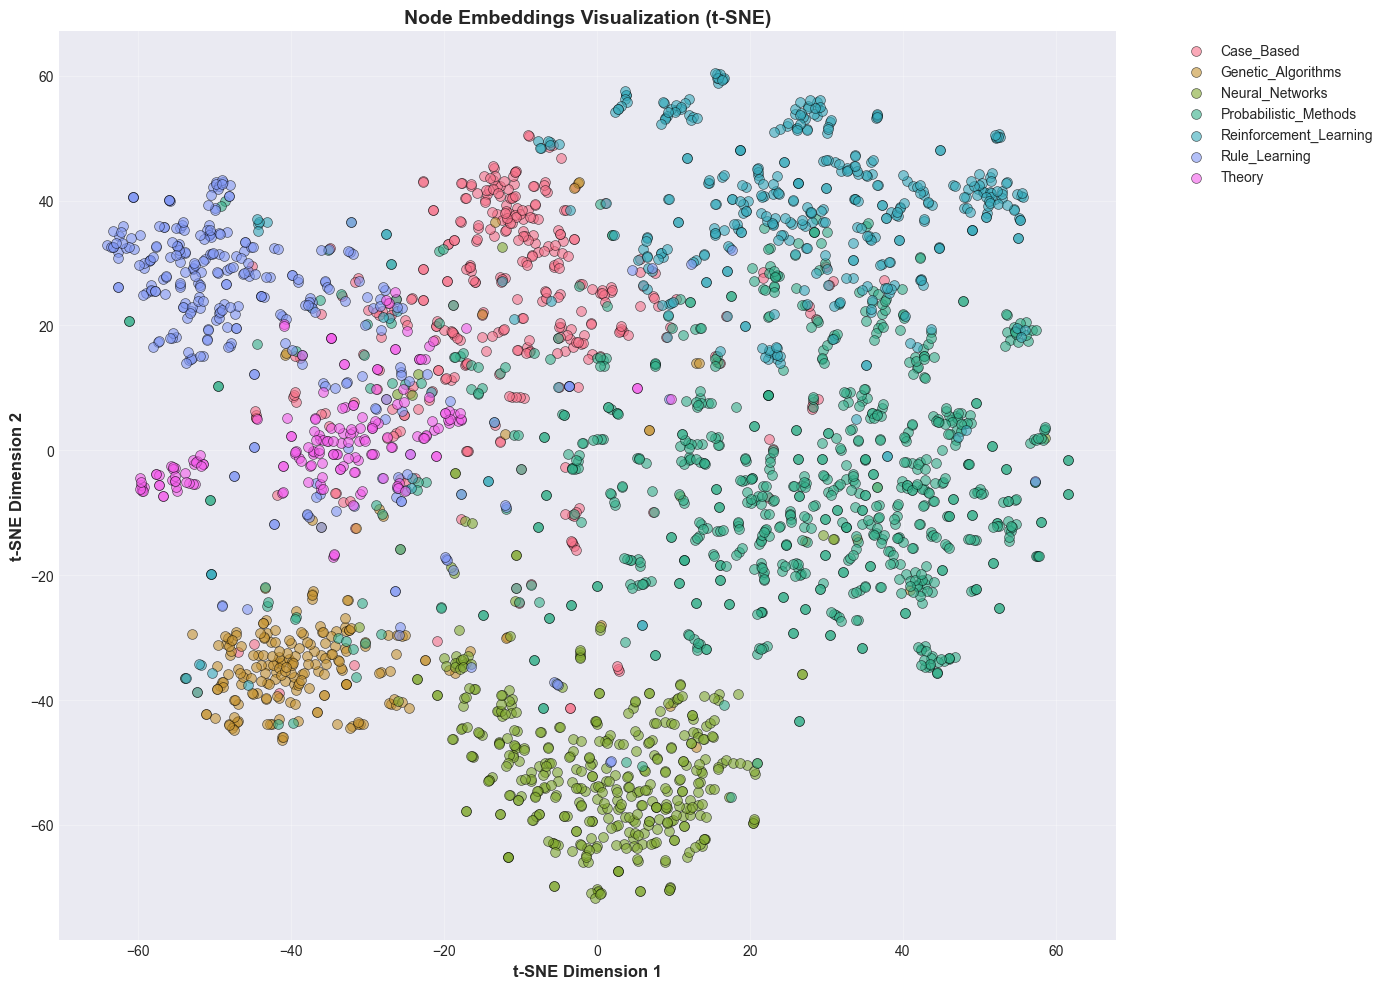

Embedding visualization complete!
Well-separated clusters indicate good learning


In [11]:
@torch.no_grad()
def get_node_embeddings(model, data):
    model.eval()
    x = data.x
    edge_index = data.edge_index
    x = model.conv1(x, edge_index)
    x = model.norm1(x)
    x = F.elu(x)
    return x.cpu().numpy()

def visualize_embeddings(model, data):
    embeddings = get_node_embeddings(model, data)
    labels = data.y.cpu().numpy()
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    embeddings_2d = tsne.fit_transform(embeddings)
    class_names = [
        'Case_Based', 'Genetic_Algorithms', 'Neural_Networks',
        'Probabilistic_Methods', 'Reinforcement_Learning',
        'Rule_Learning', 'Theory'
    ]
    colors = sns.color_palette("husl", 7)
    
    # Plot
    plt.figure(figsize=(14, 10))
    for i, name in enumerate(class_names):
        mask = labels == i
        plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                   c=[colors[i]], label=name, alpha=0.6, s=50, edgecolors='black', linewidths=0.5)
    plt.xlabel('t-SNE Dimension 1', fontsize=12, fontweight='bold')
    plt.ylabel('t-SNE Dimension 2', fontsize=12, fontweight='bold')
    plt.title('Node Embeddings Visualization (t-SNE)', fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    print("Embedding visualization complete!")
    print("Well-separated clusters indicate good learning")
visualize_embeddings(model, data)

## Attention Weights Visualization

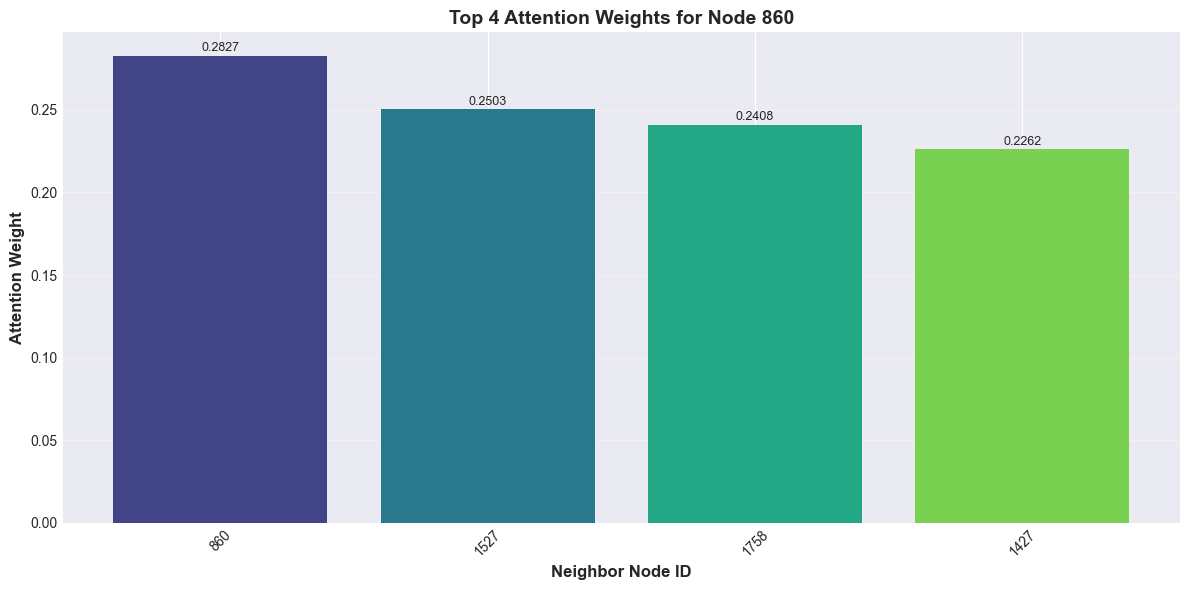


Node 860 Information:
   Class: 2
   Total neighbors: 4
   Average attention weight: 0.2500


In [12]:
@torch.no_grad()
def visualize_attention_weights(model, data, node_idx: int = 0, top_k: int = 10):
    model.eval()
    _, attention_weights = model(data.x, data.edge_index, return_attention_weights=True)
    edge_index, alpha = attention_weights['layer1']
    mask = edge_index[1] == node_idx 
    neighbor_edges = edge_index[:, mask]
    neighbor_weights = alpha[mask].cpu()
    if len(neighbor_weights) == 0:
        print(f"Node {node_idx} has no incoming edges")
        return
    neighbor_weights = neighbor_weights.mean(dim=1)
    top_k = min(top_k, len(neighbor_weights))
    top_indices = neighbor_weights.argsort(descending=True)[:top_k]
    
    top_neighbors = neighbor_edges[0, top_indices].cpu().numpy()
    top_weights = neighbor_weights[top_indices].numpy()
    
    # Plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(top_k), top_weights, color=sns.color_palette("viridis", top_k))
    plt.xlabel('Neighbor Node ID', fontsize=12, fontweight='bold')
    plt.ylabel('Attention Weight', fontsize=12, fontweight='bold')
    plt.title(f'Top {top_k} Attention Weights for Node {node_idx}', 
              fontsize=14, fontweight='bold')
    plt.xticks(range(top_k), top_neighbors, rotation=45)
    plt.grid(axis='y', alpha=0.3)
    for i, (bar, weight) in enumerate(zip(bars, top_weights)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{weight:.4f}', ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()
    
    print(f"\nNode {node_idx} Information:")
    print(f"   Class: {data.y[node_idx].item()}")
    print(f"   Total neighbors: {len(neighbor_weights)}")
    print(f"   Average attention weight: {neighbor_weights.mean():.4f}")
random_node = np.random.randint(0, data.num_nodes)
visualize_attention_weights(model, data, node_idx=random_node, top_k=15)

## Save the Trained Model

In [13]:
def save_model(model, path: str = './gat_model.pt'):
    torch.save({
        'model_state_dict': model.state_dict(),
        'num_features': dataset.num_features,
        'num_classes': dataset.num_classes,
    }, path)
    print(f"\nModel saved to: {path}")
def load_model(path: str = './gat_model.pt'):
    checkpoint = torch.load(path)
    model = GraphAttentionNetwork(
        num_features=checkpoint['num_features'],
        num_classes=checkpoint['num_classes']
    ).to(device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"\nModel loaded from: {path}")
    return model
save_model(model)


Model saved to: ./gat_model.pt
